### This ipynb is paired with a seperate pdf document with my reflections. The reflection will refer to code in this file. Each code block is labeled with a header on top of the code.

# Cell Block 1: First model (Daily Data)
Uses previous day's data to predict today's New York high temp.

In [1069]:
import requests
from bs4 import BeautifulSoup
import pardata
import json
import pandas as pd
import numpy as np
def gather_data():
    #Source 1
    url = 'https://www.extremeweatherwatch.com/cities/new-york/year-2016'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    if response.status_code == 200:
        # The request was successful
        page_content = response.text
    else:
        # Handle errors
        print('Failed to retrieve the web page.')

    precipitation = []
    snow = []
 

    monthly_table = soup.find_all('div', class_="responsive")
    for month in monthly_table:
        for day in month.find_all('tr'):
            if len(day.find_all('th')) > 0:
                continue
            td = day.find_all('td')
            for d in range(1, len(td)):
                if d == 3:
                    precipitation.append(float(td[d].text.strip()))
                elif d == 4:
                    snow.append(float(td[d].text.strip()))

    #Source 2

    data = pardata.load_dataset('noaa_jfk')
    humidity = []
#    dew_point_temp = []
    for i in range(366):
        humidity.append(data['jfk_weather_cleaned']['HOURLYRelativeHumidity'][52583 + i * 24])
#         dew_point_temp.append(data['jfk_weather_cleaned']['HOURLYDewPointTempF'][52583 + i * 24])

#https://www.visualcrossing.com/weather/weather-data-services
    #Source 3
    
    meteo = requests.get('https://archive-api.open-meteo.com/v1/archive?latitude=40.7143&longitude=-74.006&start_date=2016-01-01&end_date=2016-12-31&daily=windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum&temperature_unit=fahrenheit&windspeed_unit=mph&timezone=America%2FNew_York')
    response = meteo.json()
    windspeed = response['daily']['windspeed_10m_max']
    windgust = response['daily']['windgusts_10m_max']


    #Source 4
    def parse_weatherstack(link, moon_illumination, sunhour, uv_index):
        weather = requests.get(link)
        response = weather.json()
        for k in response['historical']:
            moon_illumination.append(response['historical'][k]['astro']['moon_illumination'])
            sunhour.append(response['historical'][k]['sunhour'])
            uv_index.append(response['historical'][k]['uv_index'])

    weather = requests.get('http://api.weatherstack.com/historical?access_key=2dfa4bd70c41886bd5acf5f62177ac72&query=New York&historical_date_start=2017-01-01&historical_date_end=2017-02-28')
    response = weather.json()
    moon_illumination = []
    sunhour = []
    uv_index = []
    parse_weatherstack('http://api.weatherstack.com/historical?access_key=2dfa4bd70c41886bd5acf5f62177ac72&query=New York&historical_date_start=2016-01-01&historical_date_end=2016-02-28', moon_illumination, sunhour, uv_index)
    parse_weatherstack('http://api.weatherstack.com/historical?access_key=2dfa4bd70c41886bd5acf5f62177ac72&query=New York&historical_date_start=2016-02-29&historical_date_end=2016-04-26', moon_illumination, sunhour, uv_index)
    parse_weatherstack('http://api.weatherstack.com/historical?access_key=2dfa4bd70c41886bd5acf5f62177ac72&query=New York&historical_date_start=2016-04-27&historical_date_end=2016-06-24', moon_illumination, sunhour, uv_index)
    parse_weatherstack('http://api.weatherstack.com/historical?access_key=2dfa4bd70c41886bd5acf5f62177ac72&query=New York&historical_date_start=2016-06-25&historical_date_end=2016-08-22', moon_illumination, sunhour, uv_index)
    parse_weatherstack('http://api.weatherstack.com/historical?access_key=2dfa4bd70c41886bd5acf5f62177ac72&query=New York&historical_date_start=2016-08-23&historical_date_end=2016-10-20', moon_illumination, sunhour, uv_index)
    parse_weatherstack('http://api.weatherstack.com/historical?access_key=2dfa4bd70c41886bd5acf5f62177ac72&query=New York&historical_date_start=2016-10-21&historical_date_end=2016-12-18', moon_illumination, sunhour, uv_index)
    parse_weatherstack('http://api.weatherstack.com/historical?access_key=2dfa4bd70c41886bd5acf5f62177ac72&query=New York&historical_date_start=2016-12-19&historical_date_end=2016-12-31', moon_illumination, sunhour, uv_index)

    #Source 5
    #https://www.kaggle.com/datasets/mathijs/weather-data-in-new-york-city-2016
    
    data = pd.read_csv('weather_data_nyc_centralpark_2016(1).csv')
    min_temp = []
    max_temp = []
    for t in data['maximum temperature']:
        max_temp.append(t)

    for t in data['minimum temperature']:
        min_temp.append(t)
        
# gather_data()

for i in range(366):
    precipitation[i] = float(precipitation[i])
    snow[i] = float(snow[i])


X = []
for i in range(365):
    curr = []
    curr.append(precipitation[i])
    curr.append(snow[i])
    curr.append(humidity[i])
    curr.append(windspeed[i])
    curr.append(windgust[i])
    curr.append(moon_illumination[i])
    curr.append(sunhour[i])
    curr.append(uv_index[i])
    curr.append(min_temp[i])
    curr.append(max_temp[i])
    X.append(curr)

X=np.matrix(X).T
Y=np.matrix(max_temp[1:])

th = np.linalg.inv(X @ X.T) @ X @ Y.T

yesterday = requests.get('http://api.weatherstack.com/historical?access_key=2dfa4bd70c41886bd5acf5f62177ac72&query=New York&historical_date=2023-09-25').json()

def c_to_f(c):
    return c*9/5 + 32

yesterday_illumination = yesterday['historical']['2023-09-25']['astro']['moon_illumination']
yesterday_mintemp = c_to_f(yesterday['historical']['2023-09-25']['mintemp'])
yesterday_maxtemp = c_to_f(yesterday['historical']['2023-09-25']['maxtemp'])
yesterday_totalsnow = yesterday['historical']['2023-09-25']['totalsnow']
yesterday_sunhour = yesterday['historical']['2023-09-25']['sunhour']
yesterday_uv_index = yesterday['historical']['2023-09-25']['uv_index']

# https://forecast.weather.gov/product.php?site=NWS&issuedby=NYC&product=CLI&format=CI&version=3&glossary=1&highlight=off
yesterday_humidity = 89
yesterday_windspeed = 20
yesterday_windgust = 31
yesterday_precip = 1.25

yesterday_X = []
yesterday_X.append(yesterday_precip)
yesterday_X.append(yesterday_totalsnow)
yesterday_X.append(yesterday_humidity)
yesterday_X.append(yesterday_windspeed)
yesterday_X.append(yesterday_windgust)
yesterday_X.append(yesterday_illumination)
yesterday_X.append(yesterday_sunhour)
yesterday_X.append(yesterday_uv_index)
yesterday_X.append(yesterday_mintemp)
yesterday_X.append(yesterday_maxtemp)

yesterday_X=np.matrix(yesterday_X)
temp = yesterday_X @ th
print(f'Sep 26 Prediction {temp}')

yesterday = requests.get('http://api.weatherstack.com/historical?access_key=2dfa4bd70c41886bd5acf5f62177ac72&query=New York&historical_date=2023-09-26').json()

yesterday_illumination = yesterday['historical']['2023-09-26']['astro']['moon_illumination']
yesterday_mintemp = c_to_f(yesterday['historical']['2023-09-26']['mintemp'])
yesterday_maxtemp = c_to_f(yesterday['historical']['2023-09-26']['maxtemp'])
yesterday_totalsnow = yesterday['historical']['2023-09-26']['totalsnow']
yesterday_sunhour = yesterday['historical']['2023-09-26']['sunhour']
yesterday_uv_index = yesterday['historical']['2023-09-26']['uv_index']

# https://forecast.weather.gov/product.php?site=NWS&issuedby=NYC&product=CLI&format=CI&version=3&glossary=1&highlight=off
yesterday_humidity = 84
yesterday_windspeed = 14
yesterday_windgust = 20
yesterday_precip = 0.19

yesterday_X = []
yesterday_X.append(yesterday_precip)
yesterday_X.append(yesterday_totalsnow)
yesterday_X.append(yesterday_humidity)
yesterday_X.append(yesterday_windspeed)
yesterday_X.append(yesterday_windgust)
yesterday_X.append(yesterday_illumination)
yesterday_X.append(yesterday_sunhour)
yesterday_X.append(yesterday_uv_index)
yesterday_X.append(yesterday_mintemp)
yesterday_X.append(yesterday_maxtemp)

yesterday_X=np.matrix(yesterday_X)
temp = yesterday_X @ th
print(f'Sep 27 Prediction {temp}')

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
mod = LinearRegression()

XArr = np.asarray(X.T)
YArr = np.asarray(Y.T)


X_train, X_test, y_train, first_y_test = train_test_split(XArr, YArr, test_size=0.2, random_state=42)

first_model = LinearRegression()

# Train the model on the training data
first_model.fit(X_train, y_train)

# Make predictions on the test data
first_y_pred = first_model.predict(X_test)


mse = mean_squared_error(first_y_test, first_y_pred)
r2 = r2_score(first_y_test, first_y_pred)

print(f"First Model MSE: {mse}")
print(f"R-Sqaured for first Model {r2}")

Sep 26 Prediction [[66.17921749]]
Sep 27 Prediction [[65.43587293]]
First Model MSE: 93.28822280304256
R-Sqaured for first Model 0.7403623200296787


# Cell Block 2: Second Model
Wrong data sources are used for this second model. Hourly data is now used. Uses previous hour's data to predict today's New York high temperature

In [1101]:
import requests
from bs4 import BeautifulSoup
import pardata
import json
import pandas as pd
import numpy as np

#Source 1 Open Meteo (ERA-5 Dataset)

meteo = requests.get('https://archive-api.open-meteo.com/v1/archive?latitude=40.7143&longitude=-74.006&start_date=2016-01-01&end_date=2016-12-31&hourly=temperature_2m,relativehumidity_2m,precipitation,windspeed_10m,windgusts_10m&temperature_unit=fahrenheit&windspeed_unit=mph&timezone=America%2FNew_York')
response = meteo.json()
# dict_keys(['time', 'temperature_2m', 'relativehumidity_2m', 'precipitation', 'windspeed_10m', 'windgusts_10m'])
era = {}
era['temp'] = response['hourly']['temperature_2m']
era['humidity'] = response['hourly']['relativehumidity_2m']
era['precip'] = response['hourly']['precipitation']
era['windspeed'] = response['hourly']['windspeed_10m']
era['windgust'] = response['hourly']['windgusts_10m']


#Source 2 JFK
data = pardata.load_dataset('noaa_jfk')
jfk = {}
jfk['visibility'] = []
jfk['humidity'] = []
jfk['windspeed'] = []
jfk['precip'] = []
jfk['temp'] = []
for i in range(52583, 52583 + 366 * 24):
    jfk['visibility'].append(data['jfk_weather_cleaned']['HOURLYVISIBILITY'][i])
    jfk['humidity'].append(data['jfk_weather_cleaned']['HOURLYRelativeHumidity'][i])
    jfk['windspeed'].append(data['jfk_weather_cleaned']['HOURLYWindSpeed'][i])
    jfk['precip'].append(data['jfk_weather_cleaned']['HOURLYPrecip'][i]) #In
    jfk['temp'].append(data['jfk_weather_cleaned']['HOURLYDRYBULBTEMPF'][i]) #F


# #Source 3 LaGuardia Airport (Weather.gov)
# #https://www.weather.gov/wrh/timeseries?site=KLGA&hours=72&units=english&chart=on&headers=on&obs=tabular&hourly=true&pview=standard&history=yes&start=20160101&end=20161231
data = pd.read_csv('leguarda_airport.csv')
lga = {}
lga['temp'] = data['Temperature'] #f
lga['dewpoint'] = data['Dew Point']
lga['humidity'] = data['Relative Humidity']

# #Source 4 Manhattan
# #https://www.ncei.noaa.gov/pub/data/uscrn/products/hourly02/2016/
data = pd.read_csv('manhattan_2016.csv')
manhattan = {}
manhattan['temp_max'] = data['T_MAX_F'] #F
manhattan['temp_min'] = data['T_MIN_F']
manhattan['precip'] = data['P_CALC_IN']
manhattan['temp_avg'] = data['T_HR_AVG_F']


# #source 5 Buffalo International Airport
# #https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS#
data = pd.read_csv('buffalo.csv')
buffalo = {}
buffalo['temp'] = data['TEMP'] #F
buffalo['dewpoint'] = data['DEW']
buffalo['humidity'] = data['HUMIDITY']
buffalo['wind_speed'] = data['sknt_mph']
buffalo['visibility'] = data['vsby']

dataset = []
y = []

for i in range(8784):
    curr = []
    curr.append(float(era['temp'][i]))
    curr.append(float(era['humidity'][i]))
    curr.append(float(era['precip'][i]))
    curr.append(float(era['windspeed'][i]))
    curr.append(float(era['windgust'][i]))
    curr.append(float(jfk['visibility'][i]))
    curr.append(float(jfk['humidity'][i]))
    curr.append(float(jfk['windspeed'][i]))
    curr.append(float(jfk['precip'][i]))
    curr.append(float(jfk['temp'][i]))
    curr.append(float(manhattan['temp_min'][i]))
    curr.append(float(manhattan['precip'][i]))
    curr.append(float(manhattan['temp_avg'][i]))
    curr.append(float(lga['temp'][i]))
    curr.append(float(lga['dewpoint'][i]))
    curr.append(float(lga['humidity'][i]))
    curr.append(float(buffalo['temp'][i]))
    curr.append(float(buffalo['dewpoint'][i]))
    curr.append(float(buffalo['humidity'][i]))
    curr.append(float(buffalo['wind_speed'][i]))
    curr.append(float(buffalo['visibility'][i]))
    dataset.append(curr)
    
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import check_array

# y = y[:len(y)-1]
url = 'https://www.extremeweatherwatch.com/cities/new-york/year-2016'
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

if response.status_code == 200:
    # The request was successful
    page_content = response.text
else:
    # Handle errors
    print('Failed to retrieve the web page.')

y = []

monthly_table = soup.find_all('div', class_="responsive")
for month in monthly_table:
    for day in month.find_all('tr'):
        if len(day.find_all('th')) > 0:
            continue
        td = day.find_all('td')
        for i in range(24):
            y.append(float(td[1].text.strip()))


dataset = pd.DataFrame(dataset)


X_train, X_test, y_train, second_y_test = train_test_split(dataset, y, test_size=0.2, random_state=42)

second_model = LinearRegression()

# Train the model on the training data
second_model.fit(X_train, y_train)

# Make predictions on the test data
second_y_pred = second_model.predict(X_test)


mse = mean_squared_error(second_y_test, second_y_pred)
r2 = r2_score(second_y_test, second_y_pred)



print("Mean Squared Error for 2nd Model:", mse)
print("R-squared for 2nd Model:", r2)


sep_28_predict = np.array([68.875, 57.5, 0, 2.96, 6.75, 10, 68, 18, 0, 59, 50, 0, 57, 63, 52, 80, 63, 46, 77, 9, 10])
sep_28_predict = sep_28_predict.reshape(1, -1)
y_pred = second_model.predict(sep_28_predict)
print(f'September 28 Predicition: {y_pred}')

Mean Squared Error for 2nd Model: 24.019625411550397
R-squared for 2nd Model: 0.9276015076643652
September 28 Predicition: [64.81445312]


# Cell Block 3: Third Model
Hourly data with corrected sources

In [1055]:
import requests
#Source 1 Open Meteo (ERA-5 Dataset)

meteo = requests.get('https://archive-api.open-meteo.com/v1/archive?latitude=40.7143&longitude=-74.006&start_date=2016-01-01&end_date=2016-12-31&hourly=temperature_2m,relativehumidity_2m,precipitation,windspeed_10m,windgusts_10m&temperature_unit=fahrenheit&windspeed_unit=mph&timezone=America%2FNew_York')
response = meteo.json()
# dict_keys(['time', 'temperature_2m', 'relativehumidity_2m', 'precipitation', 'windspeed_10m', 'windgusts_10m'])
era = {}
era['temp'] = response['hourly']['temperature_2m']
era['humidity'] = response['hourly']['relativehumidity_2m']
era['precip'] = response['hourly']['precipitation']
era['windspeed'] = response['hourly']['windspeed_10m']
era['windgust'] = response['hourly']['windgusts_10m']


#Source 2 JFK
# https://developer.ibm.com/exchanges/data/all/jfk-weather-data/
data = pardata.load_dataset('noaa_jfk')
jfk = {}
jfk['visibility'] = []
jfk['humidity'] = []
jfk['windspeed'] = []
jfk['precip'] = []
jfk['temp'] = []

for i in range(52583, 52583 + 366 * 24):
    jfk['visibility'].append(data['jfk_weather_cleaned']['HOURLYVISIBILITY'][i])
    jfk['humidity'].append(data['jfk_weather_cleaned']['HOURLYRelativeHumidity'][i])
    jfk['windspeed'].append(data['jfk_weather_cleaned']['HOURLYWindSpeed'][i])
    jfk['precip'].append(data['jfk_weather_cleaned']['HOURLYPrecip'][i]) #In
    jfk['temp'].append(data['jfk_weather_cleaned']['HOURLYDRYBULBTEMPF'][i]) #F


# #Source 3 LaGuardia Airport (Weather.gov)
# #https://www.weather.gov/wrh/timeseries?site=KLGA&hours=72&units=english&chart=on&headers=on&obs=tabular&hourly=true&pview=standard&history=yes&start=20160101&end=20161231
data = pd.read_csv('leguarda_airport.csv')
lga = {}
lga['temp'] = data['Temperature'] #f
lga['dewpoint'] = data['Dew Point']
lga['humidity'] = data['Relative Humidity']

# Source 4 NOAA Ithaca
#https://www.ncei.noaa.gov/pub/data/uscrn/products/hourly02/2016/CRNH0203-2016-NY_Ithaca_13_E.txt
data_text = ""
with open("ithaca_hourly.txt") as file:
    data_text = file.read()

ithaca = {}
ithaca['temp_max'] = []
ithaca['temp_min'] = []
ithaca['precip'] = []
ithaca['temp_avg'] = []
data_points = data_text.split()
for i in range(len(data_points)):
    if i % 38 == 10:
        ithaca['temp_max'].append(float(data_points[i]) * 9 / 5 + 32)
    elif i % 38 == 11:
        ithaca['temp_min'].append(float(data_points[i]) * 9 / 5 + 32)
    elif i % 38 == 12:
        ithaca['precip'].append(float(data_points[i]) * 0.0393701)
    elif i % 38 == 9:
        ithaca['temp_avg'].append(float(data_points[i]) * 9 / 5 + 32)


# #source 5 Buffalo International Airport
# #https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS#
data = pd.read_csv('buffalo.csv')
buffalo = {}
buffalo['temp'] = data['TEMP'] #F
buffalo['dewpoint'] = data['DEW']
buffalo['humidity'] = data['HUMIDITY']
buffalo['wind_speed'] = data['sknt_mph']
buffalo['visibility'] = data['vsby']
print('Data for third model successfully collected')

Data for third model successfully collected


# Cell Block 4: Finding Outliers
When checking the MSE, it's unnaturally large, so we look for outliers in the data.

Third Model Mean Squared Error (Before Removing Outlier): 13567.084956937382
Third Model R-squared (Before Removing Outlier): -39.89308136335075


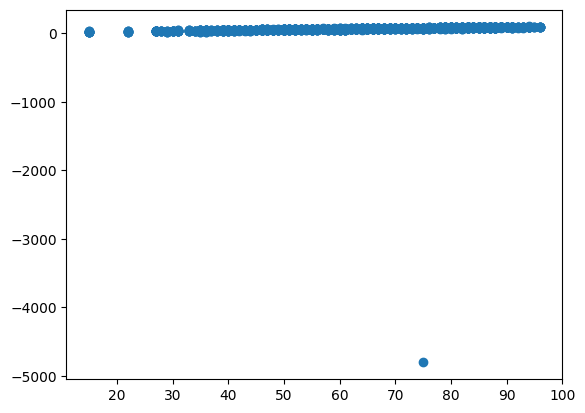

In [1074]:
import requests
from bs4 import BeautifulSoup
import pardata
import json
import pandas as pd
import numpy as np

dataset = []
y = []

for i in range(8784):
    curr = []
    curr.append(float(era['temp'][i]))
    curr.append(float(era['humidity'][i]))
    curr.append(float(era['precip'][i]))
    curr.append(float(era['windspeed'][i]))
    curr.append(float(era['windgust'][i]))
    curr.append(float(jfk['visibility'][i]))
    curr.append(float(jfk['humidity'][i]))
    curr.append(float(jfk['windspeed'][i]))
    curr.append(float(jfk['precip'][i]))
    curr.append(float(jfk['temp'][i]))
    curr.append(float(ithaca['temp_min'][i]))
    curr.append(float(ithaca['precip'][i]))
    curr.append(float(ithaca['temp_max'][i]))
    curr.append(float(lga['temp'][i]))
    curr.append(float(lga['dewpoint'][i]))
    curr.append(float(lga['humidity'][i]))
    curr.append(float(buffalo['temp'][i]))
    curr.append(float(buffalo['dewpoint'][i]))
    curr.append(float(buffalo['humidity'][i]))
    curr.append(float(buffalo['wind_speed'][i]))
    curr.append(float(buffalo['visibility'][i]))
    dataset.append(curr)

url = 'https://www.extremeweatherwatch.com/cities/new-york/year-2016'
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

if response.status_code == 200:
    # The request was successful
    page_content = response.text
else:
    # Handle errors
    print('Failed to retrieve the web page.')

y = []

monthly_table = soup.find_all('div', class_="responsive")
for month in monthly_table:
    for day in month.find_all('tr'):
        if len(day.find_all('th')) > 0:
            continue
        td = day.find_all('td')
        for i in range(24):
            y.append(float(td[1].text.strip()))
        
    
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import check_array

# y = y[:len(y)-1]
y = pd.to_numeric(y)
y = np.array(y, dtype=np.float64)


dataset = pd.DataFrame(dataset)


X_train, X_test, y_train, third_y_test = train_test_split(dataset, y, test_size=0.2, random_state=42)

third_model = LinearRegression()

# Train the model on the training data
third_model.fit(X_train, y_train)

# Make predictions on the test data
third_y_pred = third_model.predict(X_test)


mse = mean_squared_error(third_y_test, third_y_pred)
r2 = r2_score(third_y_test, third_y_pred)

print("Third Model Mean Squared Error (Before Removing Outlier):", mse)
print("Third Model R-squared (Before Removing Outlier):", r2)

plt.scatter(third_y_test, third_y_pred)

# Cell Block 5: Removing Outliers

Third Model With Outlier Removed Mean Squared Error: 24.915745095716595
Third Model With Outlier Removed R-squared: 0.9249284099783963
Sep 30 Prediction: [75.91512781]


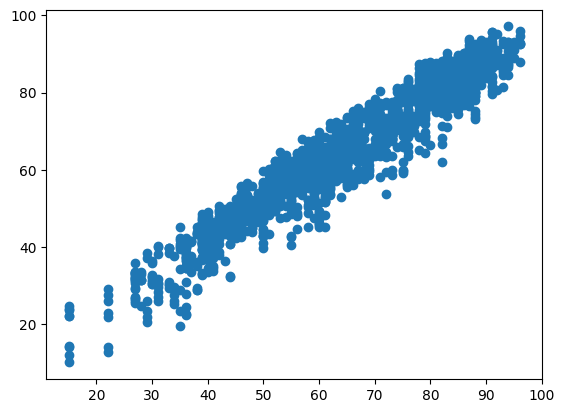

In [1084]:

X_train, X_test, y_train, third_y_test = train_test_split(dataset, y, test_size=0.2, random_state=42)

# Train the model on the training data
third_model.fit(X_train, y_train)

# Make predictions on the test data
third_y_pred = third_model.predict(X_test)

for i in range(len(third_y_pred) - 1):
    if third_y_pred[i] < -100:
        third_y_test = np.delete(third_y_test, i)
        third_y_pred = np.delete(third_y_pred, i)



mse = mean_squared_error(third_y_test, third_y_pred)
r2 = r2_score(third_y_test, third_y_pred)

print("Third Model With Outlier Removed Mean Squared Error:", mse)
print("Third Model With Outlier Removed R-squared:", r2)


                             #[68.875, 57.5, 0,  2.96,  6.75, 10, 68, 18, 0,    59, 50, 0, 57, 63, 52, 80,    63, 46, 56.7, 9, 10]
sep_30_predict = np.array([65.975, 57.75, 0, 2.96,  6.75, 10, 85, 17, 0.62, 61, 54, 0, 67, 63, 57, 87.94, 72, 55, 56.7, 4, 10])

sep_30_predict = sep_30_predict.reshape(1, -1)

plt.scatter(third_y_test, third_y_pred)

sep_30_y_pred = third_model.predict(sep_30_predict)
print(f'Sep 30 Prediction: {sep_30_y_pred}')


# Cellblock 6: Identifying Extreme Features
We see that precipitation and visibility are almost always the same. This causes big effects to the prediction when the values are not 0/10. So we remove them.

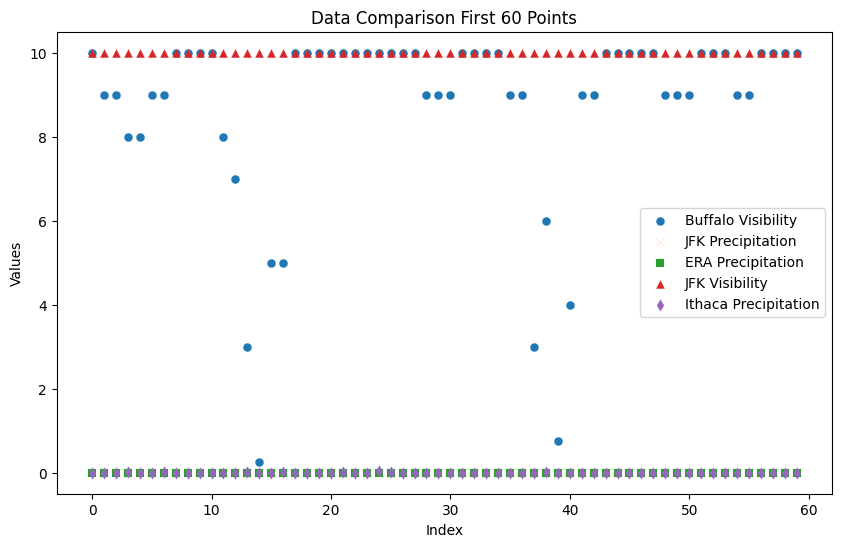

In [1003]:
import matplotlib.pyplot as plt

# Assuming all lists have the same length
x = range(len(buffalo['visibility'][:60]))  # Use the index as x values

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot for each dataset with appropriate labels and thinner dots
plt.scatter(x, buffalo['visibility'][:60], label='Buffalo Visibility', marker='o', linewidths=0.1)
plt.scatter(x, jfk['precip'][:60], label='JFK Precipitation', marker='x', linewidths=0.1)
plt.scatter(x, era['precip'][:60], label='ERA Precipitation', marker='s', linewidths=0.1)
plt.scatter(x, jfk['visibility'][:60], label='JFK Visibility', marker='^', linewidths=0.1)
plt.scatter(x, ithaca['precip'][:60], label='Ithaca Precipitation', marker='d', linewidths=0.1)

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Data Comparison First 60 Points')
plt.legend()

# Show the plot
plt.show()


# Cellblock 7: Fourth Model
We make a new model with the precipitation and visibility removed

In [1085]:
dataset = []
for i in range(8784):
    curr = []
    curr.append(float(i % 24))
    curr.append(float(era['temp'][i]))
    curr.append(float(era['humidity'][i]))
    curr.append(float(era['windspeed'][i]))
    curr.append(float(era['windgust'][i]))
    curr.append(float(jfk['humidity'][i]))
    curr.append(float(jfk['windspeed'][i]))
    curr.append(float(jfk['temp'][i]))
    curr.append(float(ithaca['temp_avg'][i]))
    curr.append(float(lga['temp'][i]))
    curr.append(float(lga['dewpoint'][i]))
    curr.append(float(lga['humidity'][i]))
    curr.append(float(buffalo['temp'][i]))
    curr.append(float(buffalo['dewpoint'][i]))
    curr.append(float(buffalo['humidity'][i]))
    curr.append(float(buffalo['wind_speed'][i]))
    dataset.append(curr)
    
dataset = pd.DataFrame(dataset)

X_train, X_test, y_train, fourth_y_test = train_test_split(dataset, y, test_size=0.2, random_state=42)

fourth_model = LinearRegression()

# Train the model on the training data
fourth_model.fit(X_train, y_train)

# Make predictions on the test data
fourth_y_pred = fourth_model.predict(X_test)

fourth_y_test = np.delete(y_test, 1215)
fourth_y_pred = np.delete(y_pred, 1215)

mse = mean_squared_error(fourth_y_test, fourth_y_pred)
r2 = r2_score(fourth_y_test, fourth_y_pred)

print("Following prints are with visibility and precipitation removed")
print("Fourth Model Mean Squared Error:", mse)
print("Fourth Model R-squared:", r2)

sep_30_predict = np.array([16, 65.975, 57.75, 2.96, 6.75, 85, 17, 61, 67, 63, 57, 87.94, 72, 55, 56.7, 4])
sep_30_predict = sep_30_predict.reshape(1, -1)
y_pred = fourth_model.predict(sep_30_predict)
print(f'Sep 30 Prediction: {y_pred}')

Following prints are with visibility and precipitation removed
Fourth Model Mean Squared Error: 24.929935011507816
Fourth Model R-squared: 0.9248730194716576
Sep 30 Prediction: [68.396512]


# Cellblock 8: Automating Data Collection for "Today"
Rather than searching up each day what the values are for each feature, we automate it through the following code

In [1062]:
from datetime import datetime, timedelta

today = []

current_date = datetime.now()
today.append(current_date.hour)
last_week = current_date - timedelta(weeks=1)
last_week = last_week.strftime('%Y-%m-%d')
response = requests.get(f'https://archive-api.open-meteo.com/v1/archive?latitude=40.7143&longitude=-74.006&start_date={last_week}&end_date={last_week}&hourly=temperature_2m,relativehumidity_2m,windspeed_10m,windgusts_10m&temperature_unit=fahrenheit&windspeed_unit=mph&precipitation_unit=inch&timezone=America%2FNew_York')
response = response.json()

for i in range(24):
    if i == current_date.hour:
        today.append(response['hourly']['temperature_2m'][i])
        today.append(response['hourly']['relativehumidity_2m'][i])
        today.append(response['hourly']['windspeed_10m'][i])
        today.append(response['hourly']['windgusts_10m'][i])
        break


response = requests.get('https://api.weather.gov/stations/KJFK/observations/latest')
jfk_response = response.json()
today.append(jfk_response['properties']['relativeHumidity']['value'])
today.append(jfk_response['properties']['windSpeed']['value'] * 0.621371)
today.append(jfk_response['properties']['temperature']['value'] * 9 / 5 + 32)

response = requests.get('https://api.weather.gov/stations/KITH/observations/latest')
ithaca_response = response.json()
today.append(ithaca_response['properties']['temperature']['value'] * 9 / 5 + 32)


response = requests.get('https://api.weather.gov/stations/KLGA/observations/latest')
lga_response = response.json()

today.append(lga_response['properties']['temperature']['value'] * 9 / 5 + 32)
today.append(lga_response['properties']['dewpoint']['value'] * 9 / 5 + 32)
today.append(lga_response['properties']['relativeHumidity']['value'])

response = requests.get('https://api.weather.gov/stations/KBUF/observations/latest')
buffalo_response = response.json()
today.append(buffalo_response['properties']['temperature']['value'] * 9 / 5 + 32)
today.append(buffalo_response['properties']['dewpoint']['value'] * 9 / 5 + 32)
today.append(buffalo_response['properties']['relativeHumidity']['value'])
today.append(buffalo_response['properties']['windSpeed']['value'] * 0.621371)
# Buffalo International Airport sometimes does not have windSpeed available. This issue is fixed in the next model.

today = np.array(today)
today = today.reshape(1, -1)
y_pred = fourth_model.predict(today)
d = current_date.strftime('%Y-%m-%d')
print(f'Fourth model prediction for today, which is {d}: {y_pred}')

Fourth model prediction for today, which is 2023-10-09: [66.33548226]


# Cellblock 9: Fifth Model
Instead of only looking at the previous hour, we use the previous 24 hours to predict the next hour

In [1086]:
dataset = []
for i in range(24, 8784):
    curr = []
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(hr % 24))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(era['temp'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(era['humidity'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(era['windspeed'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(era['windgust'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(jfk['humidity'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(jfk['windspeed'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(jfk['temp'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(ithaca['temp_avg'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(lga['temp'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(lga['dewpoint'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(lga['humidity'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(buffalo['temp'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(buffalo['dewpoint'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(buffalo['humidity'][hr]))
    for j in range(24):
        hr = i - 24 + j
        curr.append(float(buffalo['wind_speed'][hr]))
    dataset.append(curr)
    
dataset = pd.DataFrame(dataset)

new_y = y[24:]
X_train, X_test, y_train, fifth_y_test = train_test_split(dataset, new_y, test_size=0.2, random_state=42)

fifth_model = LinearRegression()

# Train the model on the training data
fifth_model.fit(X_train, y_train)

# Make predictions on the test data
fifth_y_pred = fifth_model.predict(X_test)

mse = mean_squared_error(fifth_y_test, fifth_y_pred)
r2 = r2_score(fifth_y_test, fifth_y_pred)

print("Fifth Model Mean Squared Error:", mse)
print("Fifth Model R-squared:", r2)

Fifth Model Mean Squared Error: 18.456505088789978
Fifth Model R-squared: 0.9446337037307705


# Cellblock 9: Automating Data Collection for the Past 24 Hours
Manually inputting all features for the past 24 hours is not realistic. Instead we automate finding the input. The input is empty sometimes and we use the average during that case.

In [1087]:
from datetime import datetime, timedelta
import urllib.parse

today = []

current_date = datetime.now()
begin_last_week = (current_date - timedelta(weeks=1) - timedelta(days=1)).strftime('%Y-%m-%d')
end_last_week = (current_date - timedelta(weeks=1)).strftime('%Y-%m-%d')

# Format it as a string in the desired format
formatted_date = (current_date- timedelta(hours=1)).strftime("%Y-%m-%dT%H:%M:%S")
formatted_begin_date = (current_date - timedelta(days=1) - timedelta(hours=1)).strftime("%Y-%m-%dT%H:%M:%S")

# URL-encode the formatted date string
url_encoded_date = urllib.parse.quote(formatted_date)
url_encoded_begin = urllib.parse.quote(formatted_begin_date)

# Print the URL-encoded date

response = requests.get(f'https://archive-api.open-meteo.com/v1/archive?latitude=40.7143&longitude=-74.006&start_date={begin_last_week}&end_date={end_last_week}&hourly=temperature_2m,relativehumidity_2m,windspeed_10m,windgusts_10m&temperature_unit=fahrenheit&windspeed_unit=mph&precipitation_unit=inch&timezone=America%2FNew_York')
response = response.json()

for i in range(24):
    today.append(i)
    counter += 1
for i in range(24):
    today.append(response['hourly']['temperature_2m'][i])
    counter += 1
for i in range(24):
    today.append(response['hourly']['relativehumidity_2m'][i])
    counter += 1
for i in range(24):
    today.append(response['hourly']['windspeed_10m'][i])
    counter += 1
for i in range(24):
    today.append(response['hourly']['windgusts_10m'][i])
    counter += 1
    

def filter_dates(json):
    hourly_data = {}
    for item in json['features']:
        timestamp = item['id'].split('/')[-1]  # Extract the timestamp
        hour = timestamp.split('T')[1][:2]     # Extract the hour part
        if hour not in hourly_data or timestamp > hourly_data[hour]['id']:
            hourly_data[hour] = item
    
    filtered_data = list(hourly_data.values())
    while len(filtered_data) < 24:
        last_data_point = filtered_data[-1]
        filtered_data.append(last_data_point)
    return filtered_data

response = requests.get(f'https://api.weather.gov/stations/KJFK/observations?start={url_encoded_begin}-04%3A00&end={url_encoded_date}-04%3A00')
jfk_response = response.json()

filtered_data = filter_dates(jfk_response)
total = 0
count = 0
for d in reversed(filtered_data):
    if d['properties']['relativeHumidity']['value'] == None:
        today.append(total/count)
    else:
        today.append(d['properties']['relativeHumidity']['value'])
        total += d['properties']['relativeHumidity']['value']
        count += 1
        
filtered_data = filter_dates(jfk_response)
total = 20
count = 1
for d in reversed(filtered_data):
    if d['properties']['windSpeed']['value'] == None:
        today.append(total/count * 0.621371)
    else:
        today.append(d['properties']['windSpeed']['value'] * 0.621371)
        total += d['properties']['windSpeed']['value']
        count += 1
total = 0
count = 0
for d in reversed(filtered_data):
    if d['properties']['temperature']['value'] == None:
        today.append(total/count * 9 / 5 + 32)
        counter += 1
    else:
        today.append(d['properties']['temperature']['value'] * 9 / 5 + 32)
        total += d['properties']['temperature']['value']
        count += 1
        counter += 1

response = requests.get(f'https://api.weather.gov/stations/KITH/observations?start={url_encoded_begin}-04%3A00&end={url_encoded_date}-04%3A00')
ithica_response = response.json()
filtered_data = filter_dates(ithica_response)

total = 0
count = 0
for d in reversed(filtered_data):
    if d['properties']['temperature']['value'] == None:
        today.append(total/count * 9 / 5 + 32)
    else:
        today.append(d['properties']['temperature']['value'] * 9 / 5 + 32)
        total += d['properties']['temperature']['value']
        count += 1
    
response = requests.get(f'https://api.weather.gov/stations/KLGA/observations?start={url_encoded_begin}-04%3A00&end={url_encoded_date}-04%3A00')
lga_response = response.json()

filtered_data = filter_dates(lga_response)
total = 0
count = 0
for d in reversed(filtered_data):
    if d['properties']['temperature']['value'] == None:
        today.append(total/count * 9 / 5 + 32)
    else:
        today.append(d['properties']['temperature']['value'] * 9 / 5 + 32)
        total += d['properties']['temperature']['value']
        count += 1
total = 0
count = 0
for d in reversed(filtered_data):
    if d['properties']['dewpoint']['value'] == None:
        today.append(total/count * 9 / 5 + 32)
    else:
        today.append(d['properties']['dewpoint']['value'] * 9 / 5 + 32)
        total += d['properties']['dewpoint']['value']
        count += 1

total = 0
count = 0
for d in reversed(filtered_data):
    if d['properties']['relativeHumidity']['value'] == None:
        today.append(total/count) 
    else:
        today.append(d['properties']['relativeHumidity']['value'])
        total += d['properties']['relativeHumidity']['value']
        count += 1

response = requests.get(f'https://api.weather.gov/stations/KBUF/observations?start={url_encoded_begin}-04%3A00&end={url_encoded_date}-04%3A00')
buffalo_response = response.json()
filtered_data = filter_dates(buffalo_response)

total = 0
count = 0
for d in filtered_data:
    if d['properties']['temperature']['value'] == None:
        today.append(total/count * 9 / 5 + 32)
        counter += 1
    else:
        today.append(d['properties']['temperature']['value'] * 9 / 5 + 32)
        total += d['properties']['temperature']['value']
        count += 1
        counter += 1
    
total = 0
count = 0
for d in reversed(filtered_data):
    if d['properties']['dewpoint']['value'] == None:
        today.append(total/count * 9 / 5 + 32)
    else:
        today.append(d['properties']['dewpoint']['value'] * 9 / 5 + 32)
        total += d['properties']['dewpoint']['value']
        count += 1

total = 0
count = 0
for d in reversed(filtered_data):
    if d['properties']['relativeHumidity']['value'] == None:
        today.append(total/count)
    else:
        today.append(d['properties']['relativeHumidity']['value'])
        total += d['properties']['relativeHumidity']['value']
        count += 1

total = 20
count = 1
for d in filtered_data:
    if d['properties']['windSpeed']['value'] == None:
        today.append(total/count * 0.621371)
    else:
        today.append(d['properties']['windSpeed']['value'] * 0.621371)
        total += d['properties']['windSpeed']['value']
        count += 1

today = np.array(today)
today = today.reshape(1, -1)
y_pred = fifth_model.predict(today)
d = current_date.strftime('%Y-%m-%d Hour %H')
print(f'Fifth model prediction for today, which is {d}: {y_pred}')

Fifth model prediction for today, which is 2023-10-09 Hour 22: [75.44482749]


# Cellblock 10: Automating Buying in Kalshi
After receiving our prediction, we can buy by inputting y_pred and running the code block below

In [875]:
y_pred = 76.20545788 # SET THE PREDICTION HERE


# Welcome to the Kalshi REST v2 Starter Code!

# pypi client: recommended for more advanced programmers
import kalshi_python
 
# starter client: recommended for all levels of programming experience (what this client is implemented using)
from KalshiClientsBaseV2 import ExchangeClient
import time
import json
import uuid

# To start off, you need to have created an account at https://kalshi.com (Production) 
# or an account on the Demo https://demo.kalshi.co/

prod_email = "" # change these to be your personal credentials
prod_password = "" # (for extra security, we recommend using a config file)

demo_email = "simonkye@bu.edu" # change these to be your personal credentials
demo_password = "Simon200560!" # (for extra security, we recommend using a config file)

# for prod
prod_api_base = "https://trading-api.kalshi.com/trade-api/v2"

# for demo
demo_api_base = "https://demo-api.kalshi.co/trade-api/v2"

## if wanting to test in prod:
# exchange_client = ExchangeClient(exchange_api_base=prod_api_base, email = prod_email, password = prod_password)

## if wanting to test in demo
exchange_client = ExchangeClient(exchange_api_base = demo_api_base, email = demo_email, password = demo_password)

from datetime import datetime

# Get today's date
today = datetime.now()

# Format the date as "23OCT09"
formatted_date = today.strftime("%y%b%d") 
formatted_date = formatted_date.upper()

formatted_ticker = 'HIGHNY-' + formatted_date

market_params = {'limit':100,
                    'cursor':None, # passing in the cursor from the previous get_markets call
                    'event_ticker': None,
                    'series_ticker':'HIGHNY',
                    'max_close_ts':None, # pass in unix_ts
                    'min_close_ts':None, # pass in unix_ts
                    'status':None,
                    'tickers':None}

markets_response = exchange_client.get_markets(**market_params)
cursor = markets_response['cursor']

event_params = {'event_ticker': formatted_ticker}
event_response = exchange_client.get_event(**event_params)
event_ticker = ""

if event_response['markets'][0]['cap_strike'] > y_pred:
    event_ticker = event_response['markets'][0]['ticker']
elif event_response['markets'][-1]['floor_strike'] < y_pred:
    event_ticker = event_response['markets'][-1]['ticker']
else:
    for market in event_response['markets']:
        if round(y_pred) == market['cap_strike'] or round(y_pred) == market['floor_strike']:
            event_ticker = market['ticker']
            
print(event_ticker)

order_params = {'ticker':event_ticker,
                    'client_order_id':str(uuid.uuid4()),
                    'type':'limit',
                    'action':'buy',
                    'side':'yes',
                    'count':1000,
                    'yes_price':10, # yes_price = 100 - no_price
                    'no_price':None, # no_price = 100 - yes_price
                    'expiration_ts':None,
                    'sell_position_floor':None,
                    'buy_max_cost':None}

exchange_client.create_order(**order_params)

# Cellblock 11: Determining which hour to buy
We determine to buy at 10am as it's too early for the high temp to be known and has a relatively low MSE

In [1045]:
y_test_hours = []
y_pred_hours = []

for i in range(24):
    y_test_hours.append([])
    y_pred_hours.append([])
for i in range(len(y_test)):
    y_test_hours[i % 24].append(y_test[i])
    y_pred_hours[i % 24].append(y_pred[i])

best_hour = 0
min_mse = 10000
max_r2 = 0

for i in range(len(y_test_hours)):
    print(f'hour {i}: {mean_squared_error(y_test_hours[i], y_pred_hours[i])}')
    if min_mse > mean_squared_error(y_test_hours[i], y_pred_hours[i]):
        min_mse = mean_squared_error(y_test_hours[i], y_pred_hours[i])
        max_r2 = r2_score(y_test, y_pred)
        best_hour = i


hour 0: 21.267080022044063
hour 1: 18.00712488256629
hour 2: 23.269888437421113
hour 3: 20.851910094643145
hour 4: 19.691511301592413
hour 5: 15.273312140409338
hour 6: 22.058351209134653
hour 7: 15.352764988223875
hour 8: 22.782709292899543
hour 9: 20.214286539695276
hour 10: 14.173480021688416
hour 11: 18.261747501203004
hour 12: 18.087169066556562
hour 13: 18.87633329167532
hour 14: 12.014271986965014
hour 15: 19.65783777970433
hour 16: 12.783319994136892
hour 17: 12.400662315926338
hour 18: 19.382853223151503
hour 19: 18.8086798848635
hour 20: 20.163989331105604
hour 21: 18.697676716866948
hour 22: 18.482755845201318
hour 23: 22.396406263285016


# Cellblock 12: Sixth Model
We use ridge regression to normalize any extreme coefficients in the model.

In [1089]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, sixth_y_test = train_test_split(dataset, new_y, test_size=0.2, random_state=42)

# Create a Ridge Regression model with regularization strength (alpha)
alpha = 15000  # You can adjust alpha for different levels of regularization
ridge_model = Ridge(alpha=alpha)

# Fit the model to your training data
ridge_model.fit(X_train, y_train)

# Make predictions on the test data
sixth_y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(sixth_y_test, sixth_y_pred)
print("Sixth Model: Mean Squared Error:", mse)
print("Sixth Model: R-squared:", r2)

Sixth Model: Mean Squared Error: 17.958062331851767
Sixth Model: R-squared: 0.9446337037307705


# Cellblock 13: Balance Visualization

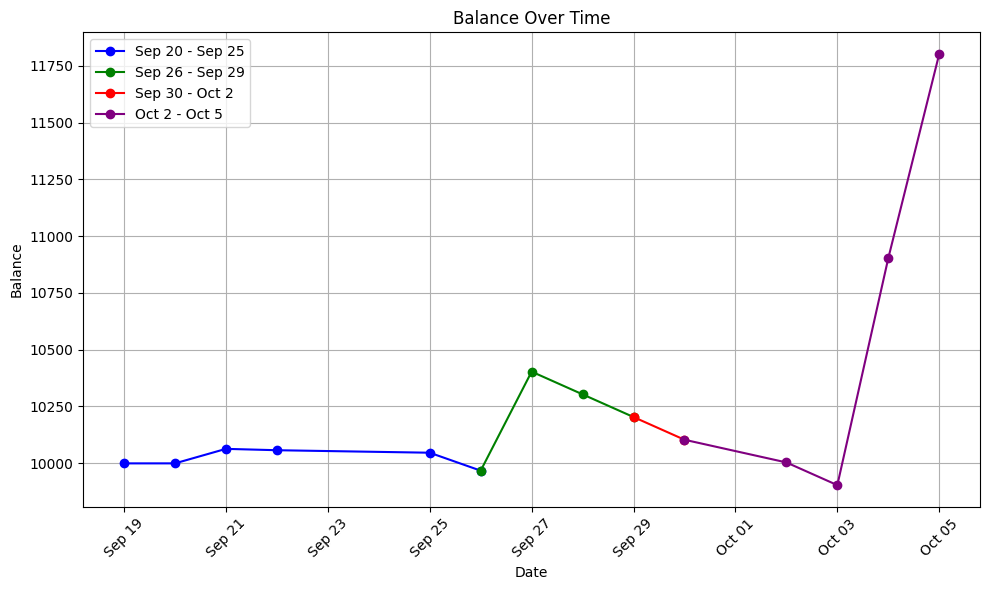

In [1102]:
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Your balance data
balance = [9999, 9999.06, 10062.96, 10056.96, 10045.96, 9966.92, 10403.11, 10303.11, 10203.11, 10103.11, 10003.11, 9903.11, 10903.01, 11803.01]

# Your corresponding dates as strings
date_strings = ['Sep 19','Sep 20', 'Sep 21', 'Sep 22', 'Sep 25', 'Sep 26', 'Sep 27', 'Sep 28', 'Sep 29', 'Sep 30', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5']

# Convert date strings to datetime objects
dates = [datetime.strptime(date, '%b %d') for date in date_strings]

# Define the segments and their corresponding colors
segments = [
    (dates[:6], balance[:6], 'blue', 'Sep 20 - Sep 25'),
    (dates[5:9], balance[5:9], 'green', 'Sep 26 - Sep 29'),
    (dates[8:10], balance[8:10], 'red', 'Sep 30 - Oct 2'),
    (dates[9:], balance[9:], 'purple', 'Oct 2 - Oct 5')
]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

for segment_dates, segment_balance, color, label in segments:
    ax.plot(segment_dates, segment_balance, marker='o', linestyle='-', color=color, label=label)

ax.set_xlabel('Date')
ax.set_ylabel('Balance')
ax.set_title('Balance Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


# Cellblock 14: Prediction Visualization

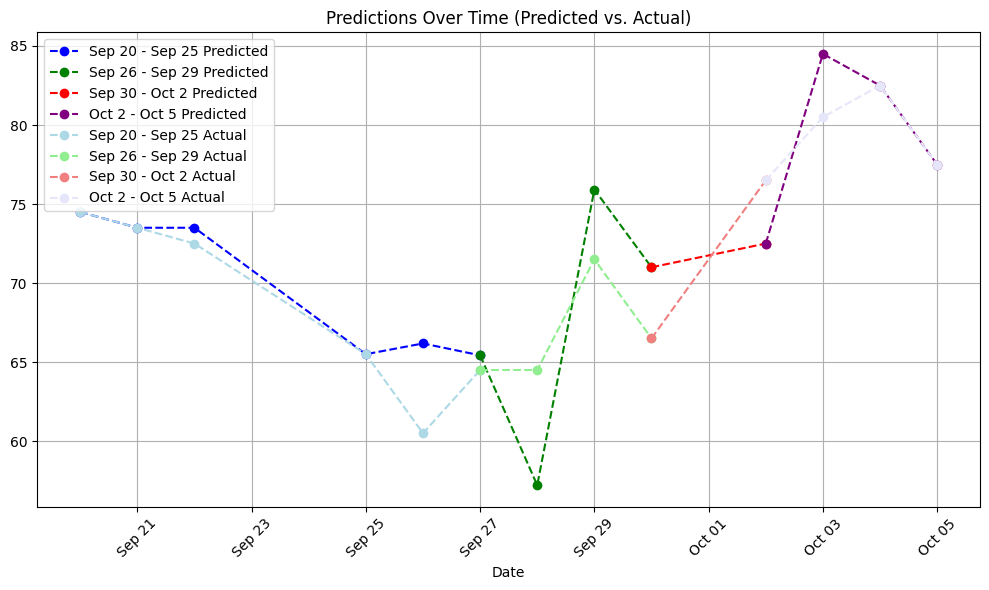

In [1103]:
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Your corresponding dates as strings
date_strings = ['Sep 20', 'Sep 21', 'Sep 22', 'Sep 25', 'Sep 26', 'Sep 27', 'Sep 28', 'Sep 29', 'Sep 30', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5']

# Convert date strings to datetime objects
dates = [datetime.strptime(date, '%b %d') for date in date_strings]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Add predicted and actual values
predicted_values = [74.5, 73.5, 73.5, 65.5, 66.18, 65.43, 57.21, 75.92, 71, 72.5, 84.5, 82.5, 77.5]
actual_values = [74.5, 73.5, 72.5, 65.5, 60.5, 64.5, 64.5, 71.5, 66.5, 76.5, 80.5, 82.5, 77.5]

# Define the segments and their corresponding colors
segments = [
    (dates[:6], predicted_values[:6], 'blue', 'Sep 20 - Sep 25 Predicted'),
    (dates[5:9], predicted_values[5:9], 'green', 'Sep 26 - Sep 29 Predicted'),
    (dates[8:10], predicted_values[8:10], 'red', 'Sep 30 - Oct 2 Predicted'),
    (dates[9:], predicted_values[9:], 'purple', 'Oct 2 - Oct 5 Predicted'),
    (dates[:6], actual_values[:6], 'lightblue', 'Sep 20 - Sep 25 Actual'),
    (dates[5:9], actual_values[5:9], 'lightgreen', 'Sep 26 - Sep 29 Actual'),
    (dates[8:10], actual_values[8:10], 'lightcoral', 'Sep 30 - Oct 2 Actual'),
    (dates[9:], actual_values[9:], 'lavender', 'Oct 2 - Oct 5 Actual'),
]

for segment_dates, segment_values, color, label in segments:
    ax.plot(segment_dates, segment_values, marker='o', linestyle='--', color=color, label=label)

ax.set_xlabel('Date')
ax.set_title('Predictions Over Time (Predicted vs. Actual)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


# Cellblock 15: Performance Visualization

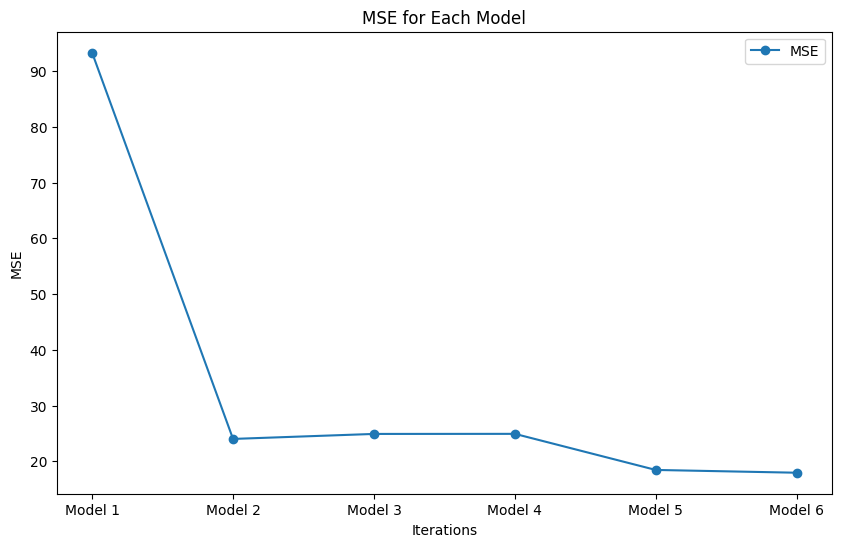

In [1109]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming you have the y_pred and y_test variables for each iteration
# For example, first_y_pred, first_y_test, second_y_pred, second_y_test, and so on...

# Create lists to store metrics for each iteration
mse_values = []
mae_values = []
r2_values = []

# Loop through each iteration
y_pred = first_y_pred
y_test = first_y_test  

# Calculate metrics for the current iteration
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Append metrics to the respective lists
mse_values.append(mse)
mae_values.append(mae)
r2_values.append(r2)

# Loop through each iteration
y_pred = second_y_pred
y_test = second_y_test  

# Calculate metrics for the current iteration
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Append metrics to the respective lists
mse_values.append(mse)
mae_values.append(mae)
r2_values.append(r2)

y_pred = third_y_pred
y_test = third_y_test  

# Calculate metrics for the current iteration
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Append metrics to the respective lists
mse_values.append(mse)
mae_values.append(mae)
r2_values.append(r2)

y_pred = fourth_y_pred
y_test = fourth_y_test  

# Calculate metrics for the current iteration
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Append metrics to the respective lists
mse_values.append(mse)
mae_values.append(mae)
r2_values.append(r2)

y_pred = fifth_y_pred
y_test = fifth_y_test  

# Calculate metrics for the current iteration
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Append metrics to the respective lists
mse_values.append(mse)
mae_values.append(mae)
r2_values.append(r2)

y_pred = sixth_y_pred
y_test = sixth_y_test  

# Calculate metrics for the current iteration
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


# Append metrics to the respective lists
mse_values.append(mse)
mae_values.append(mae)
r2_values.append(r2)



# Create a bar chart to visualize the metrics
iterations = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
plt.figure(figsize=(10, 6))
plt.plot(iterations, mse_values, label='MSE', marker='o')

plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('MSE for Each Model')
plt.legend()
plt.show()


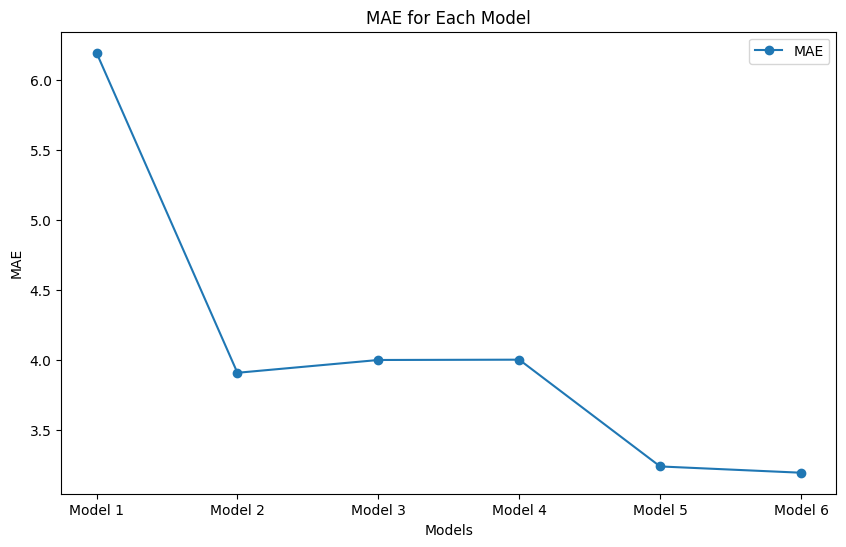

In [1110]:
# Create a bar chart to visualize the metrics
iterations = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

plt.figure(figsize=(10, 6))
plt.plot(iterations, mae_values, label='MAE', marker='o')

plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('MAE for Each Model')
plt.legend()
plt.show()

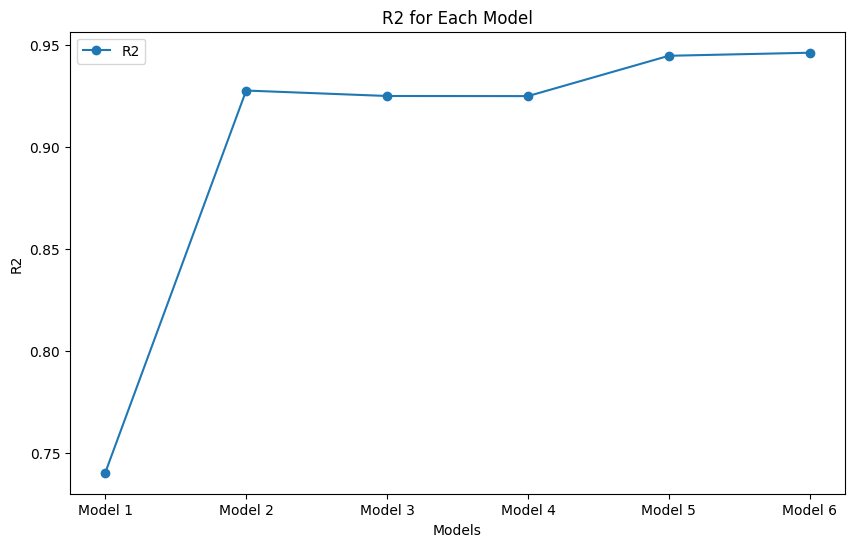

In [1112]:
# Create a bar chart to visualize the metrics
iterations = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

plt.figure(figsize=(10, 6))
plt.plot(iterations, r2_values, label='R2', marker='o')

plt.xlabel('Models')
plt.ylabel('R2')
plt.title('R2 for Each Model')
plt.legend()
plt.show()